# Размер компьютерных игры во времени на основе данных Steam

In [34]:
import requests
import time
from IPython.display import HTML
import numpy as np
import pylab
import seaborn as sns
import json
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 1. Сбор данных

Данные собирались тремя совершенно различными способами:
* первоначально было достаточно глупо случайным блужданием по страницам продуктов вида http://store.steampowered.com/app/%id%/ и выгрузкой всей страницы. Это было глупо, т.к. максимальный номер игры больше пары миллионов.
* затем была найдена немного протухшая база всех игр до 2013 года (valve.sql), откуда были взять id-шники из таблицы с жанрами и точно так же загружалась страница. Это оказалось в итоге сильно полезно, т.к. обогатило график старыми играми (почему - позже)
* последний и самый разумный метод - брался большой список всех текуших приложений с помощью Steam API http://api.steampowered.com/ISteamApps/GetAppList/v0002/, оттуда с помощью фильтрации по stop-words убирались всякие 'dlc', 'pack', 'demo' и т.д., а для всего оставшегося получался JSON с информацией методом appdetails: http://store.steampowered.com/api/appdetails?appids=57690

Сбор данных из старой базы:

In [140]:
def get_steamapp_page(number):
    url = 'http://store.steampowered.com/app/' + str(number)
    response = requests.get(url)
    time.sleep(3)
    if response.ok:
        return (number, response.content)

In [145]:
olddb = set()
with open('genres.csv') as f:
    lines = f.readlines()
    for l in lines:
        olddb.add(l.split(',')[0])
olddb = list(olddb)
len(olddb)

2821

In [146]:
jobs = jobs_manager()

In [147]:
bag1,bag2,bag3,bag4 = [],[],[],[]

In [148]:
%job [bag1.append(get_steamapp_page(olddb[x])) for x in log_progress(range(0, 650))]
%job [bag2.append(get_steamapp_page(olddb[x])) for x in log_progress(range(650, 1300))]
%job [bag3.append(get_steamapp_page(olddb[x])) for x in log_progress(range(1300, 1950))]
%job [bag4.append(get_steamapp_page(olddb[x])) for x in log_progress(range(1950, 2821))]

Starting job # 0 in a separate thread.
Starting job # 2 in a separate thread.
Starting job # 3 in a separate thread.
Starting job # 4 in a separate thread.


In [152]:
rawdata = []
rawdata.extend(bag1)
rawdata.extend(bag2)
rawdata.extend(bag3)
rawdata.extend(bag4)

In [153]:
len(rawdata) #check length

2821

In [163]:
rawdata[1277][0]

'INSERT INTO `app_genres` `appID`'

In [164]:
del data[1277] #delete unnecessary line

Теперь у нас есть ~ 300 Mb html текста для анализа.

Данные из API:

In [174]:
app_list_json = requests.get('http://api.steampowered.com/ISteamApps/GetAppList/v0002/').content

In [175]:
apps_json = json.loads(app_list_json)
len(apps_json['applist']['apps'])

27687

In [176]:
bad_words = ['trailer', 'pack', 'mode', 'map', 'add-on', 'addon', 
             'demo', 'dlc', 'video', 'edition', 'soundtrack', 'soundtracks']

In [321]:
games = []
for app in apps_json['applist']['apps']:
    if not any([substring in app['name'].lower() for substring in bad_words]):
        games.append(app)
len(games)

18201

In [179]:
for app in games[-10:]:
    print app

{u'name': u'Hardcore Henry', u'appid': 504680}
{u'name': u'Brick Stack VR', u'appid': 504840}
{u'name': u'Castle Invasion: Throne Out', u'appid': 504850}
{u'name': u'Fantasy Grounds - A08: Search For The Tri-Stone (PFRPG)', u'appid': 504870}
{u'name': u'Fire Farm VR', u'appid': 505670}
{u'name': u'Glaive', u'appid': 505680}
{u'name': u'Party Panic', u'appid': 506500}
{u'name': u'Pong Champion VR', u'appid': 506960}
{u'name': u'Just Deserts - Original Sound Track', u'appid': 507020}
{u'name': u'Lily\xb4s Epic Quest', u'appid': 507270}


In [185]:
def get_app_details(app):
    appid = app['appid']
    req = requests.get('http://store.steampowered.com/api/appdetails?appids=%s' % appid).content
    time.sleep(2)
    return json.loads(req)

In [189]:
jj = get_app_details(games[3])
print json.dumps(jj, indent=4, sort_keys=True)

{
    "10": {
        "data": {
            "about_the_game": "Play the world's number 1 online action game. Engage in an incredibly realistic brand of terrorist warfare in this wildly popular team-based game. Ally with teammates to complete strategic missions. Take out enemy sites. Rescue hostages. Your role affects your team's success. Your team's success affects your role.", 
            "achievements": {
                "total": 0
            }, 
            "background": "http://cdn.akamai.steamstatic.com/steam/apps/10/page_bg_generated_v6b.jpg?t=1447887426", 
            "categories": [
                {
                    "description": "Multi-player", 
                    "id": 1
                }, 
                {
                    "description": "Valve Anti-Cheat enabled", 
                    "id": 8
                }
            ], 
            "detailed_description": "Play the world's number 1 online action game. Engage in an incredibly realistic brand of terrorist wa

In [197]:
print '$Name: ', jj['10']['data']['name']
print '$Release: ', jj['10']['data']['release_date']['date']
print '$Type: ', jj['10']['data']['type']
print '$Requirements: ', jj['10']['data']['pc_requirements']['minimum']

$Name:  Counter-Strike
$Release:  1 Nov, 2000
$Type:  game
$Requirements:  
			<p><strong>Minimum:</strong> 500 mhz processor, 96mb ram, 16mb video card, Windows XP, Mouse, Keyboard, Internet Connection<br /></p>
			<p><strong>Recommended:</strong> 800 mhz processor, 128mb ram, 32mb+ video card, Windows XP, Mouse, Keyboard, Internet Connection<br /></p>
			


In [195]:
bag1,bag2,bag3,bag4 = [],[],[],[]

In [196]:
%job [bag1.append(get_app_details(games[x])) for x in log_progress(range(0, 4533))]
%job [bag2.append(get_app_details(games[x])) for x in log_progress(range(4533, 9066))]
%job [bag3.append(get_app_details(games[x])) for x in log_progress(range(9066, 13599))]
%job [bag4.append(get_app_details(games[x])) for x in log_progress(range(13599, 18201))]

Starting job # 9 in a separate thread.
Starting job # 10 in a separate thread.
Starting job # 11 in a separate thread.
Starting job # 12 in a separate thread.


In [198]:
rawdata_api = []
rawdata_api.extend(bag1)
rawdata_api.extend(bag2)
rawdata_api.extend(bag3)
rawdata_api.extend(bag4)

In [199]:
len(rawdata_api)

18201

Сохраним данные:

In [200]:
with open('json_raw_data.txt', 'w') as outfile:
    json.dump({'big_json' : rawdata_api}, outfile)

Оставим только игры:

In [202]:
gmdata = []
bad_ind = []
for ind, d in enumerate(rawdata_api):
    if d:
        _d = d[d.keys()[0]]
        if 'data' in _d.keys():
            _d = _d['data']
            if 'type' in _d.keys():
                _d = _d['type']
                if _d == 'game':
                    gmdata.append(d)
    else:
        bad_ind.append(ind)
len(gmdata)

4276

In [203]:
len(bad_ind)

10281

## 2. Извлечение данных

In [290]:
import datetime

def get_release_date(o):
    release = None
    if type(o) == dict:
        release = o[o.keys()[0]]['data']['release_date']['date']
    else:
        try:
            desc = o[1]
            release = desc[desc.index('Release Date:</b>')+len('Release Date:</b>'):]
            release = release[:release.index('<br>')].strip()
        except:
            release = None
    if release:
        try:
            release = datetime.datetime.strptime(release,'%d %b, %Y')
        except ValueError:
            try:
                release = datetime.datetime.strptime(release,'%b %Y')
            except ValueError:
                release = None
    return release

In [298]:
MB_in_GB = 1024

def get_size(o):
    '''game size in Mb'''
    desc = None
    storage = None
    if type(o) == dict:
        try:
            desc = o[o.keys()[0]]['data']['pc_requirements']['minimum']
        except:
            pass
    else:
        desc = o[1]
    if desc:
        desc = desc.replace(' </strong>', '')
        desc = desc.replace('</strong>', '')
        desc = desc.replace(',', '.')
        for storeword in ['Hard Drive', 'Storage', 'Drive']:
            if storeword in desc:
                storage = desc[desc.index(storeword)+len(storeword):]
        if storage:
            storage = storage.replace('+', '')
            storage = storage.replace(':', ' ')
            storage = storage.upper()
            if '-' not in storage[:10]:
                try:
                    if 'GB' in storage[:10]:
                        storage = storage[:storage.index('GB')]
                        storage = float(storage)*MB_in_GB
                    elif 'MB' in storage[:10]:
                        storage = storage[:storage.index('MB')]
                        storage = float(storage)
                    else:
                        storage = None
                except ValueError:
                    storage = None
            else:
                storage = None
    return storage

In [494]:
dates, sizes, ids = [], [], []
for game in rawdata:
    release = get_release_date(game)
    size = get_size(game)
    if size and release:
        dates.append(release)
        sizes.append(size)
        ids.append(game[0])
print len(sizes)

1376


In [495]:
dates_api, sizes_api, ids_api = [], [], []
for game in gmdata:
    release = get_release_date(game)
    size = get_size(game)
    if size and release:
        dates_api.append(release)
        sizes_api.append(size)
        ids_api.append(int(game.keys()[0]))
print len(sizes_api)

3481


Сохраним результаты:

In [304]:
f = open('size_vs_date.txt', 'a')
for l in zip(dates, sizes, ids):
    f.write(str(l)+'\n')
f.flush()
f.close()

In [306]:
f = open('size_vs_date_api.txt', 'a')
for l in zip(dates_api, sizes_api, ids_api):
    f.write(str(l)+'\n')
f.flush()
f.close()

График:

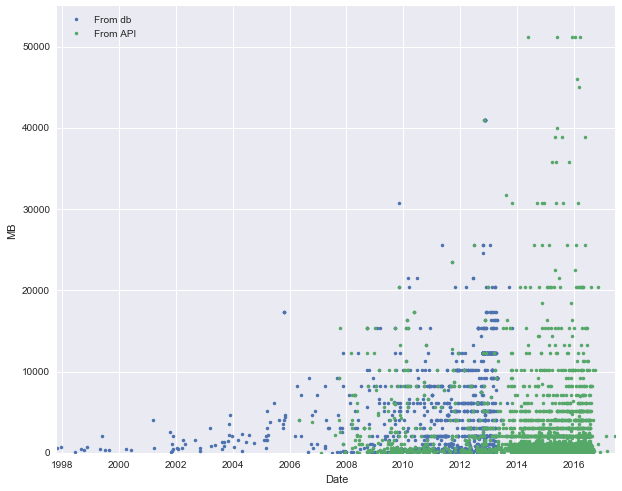

In [498]:
fig = plt.figure(figsize=[10,8])
plt.plot(dates, sizes, '.', label='From db')
plt.plot(dates_api, sizes_api, '.', label='From API')
plt.ylim(-1, 5.5e4)
plt.ylabel('MB')
plt.xlabel('Date')
plt.legend(loc='upper left')

Видно, что из API извлечены в основном современные игры, тогда как старые данные практически не тянутся дальше 2013 года, зато дают данные о множестве старых игр.  Причин тут две: в старой базе я не отделял всякие dlc от игр, что наверняка не критично, но вторая причина достаточно странная - разные даты релиза в API и на сайте. Например **Jagged Alliance 2 - Wildfire**  с appid=215930 на сайте релизнулся 8 Mar, 2004, а в API - "release_date":{"coming_soon":false,"date":"16 Nov, 2012"} (чтобы было еще страннее - на сайте GOG релиз 8 февраля 2005). В целом, это не должно значительно влиять на конечный результат.

Объединим данные и прежде, чем сравнивать с объемами жестких дисков, найдем аномалии и интересности:

In [499]:
dates.extend(dates_api)
sizes.extend(sizes_api)
ids.extend(ids_api)
dates, sizes, ids = zip(*sorted(zip(dates, sizes, ids)))
dates, sizes, ids = list(dates), list(sizes), list(ids)
ids = map(int, ids)

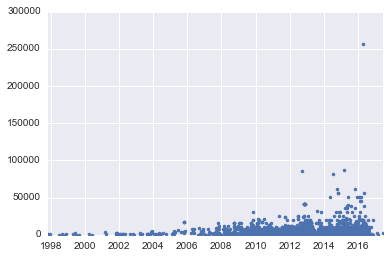

In [500]:
plt.plot(dates, sizes, '.')

Видно, что есть сильный отскок на 250+ Гб - аномалия, которую из анализа надо будет убрать.

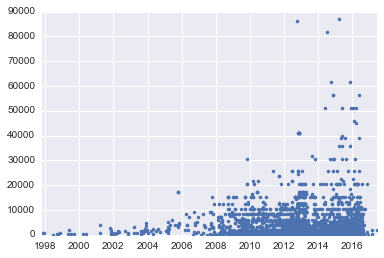

In [501]:
ind = sizes.index(max(sizes))
del sizes[ind]
del dates[ind]
del ids[ind]
plt.plot(dates, sizes, '.')

Есть еще как минимум три точки выбивающиеся, но не понятно - правдивы они или нет (это [306130](http://store.steampowered.com/app/306130),  [292180](http://store.steampowered.com/app/292180), [213155](http://store.steampowered.com/app/213155)). Из общего очень сильно выбиваются - уберем их.

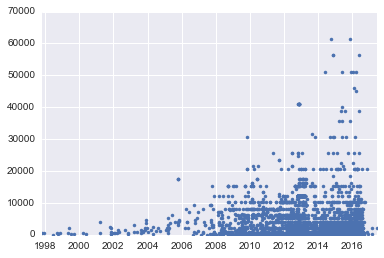

In [502]:
indexes = []
for redundant in [306130, 292180, 213155]:
    indexes.append(ids.index(redundant))
        
for ind in sorted(indexes, reverse=True):
    del sizes[ind]
    del dates[ind]
    del ids[ind]

plt.plot(dates, sizes, '.')

К сожалению, некоторые интересности были получены из случайных блужданий и не могут быть воспроизведены. К тому же данные по релизам - это просто визуальный просмотр нераспарсившихся дат.

### Интересности: 

* http://store.steampowered.com/app/273620 - 2490 GB (вот это я понимаю размер)
* http://store.steampowered.com/app/300790 - 500 GB
* http://store.steampowered.com/app/439730 - 250 GB
* http://store.steampowered.com/app/291860 - release 'Before the Apocalypse' (О - оптимизм)
* http://store.steampowered.com/app/355680 - Release Date: When The World Ends (П - Пессимизм)
* http://store.steampowered.com/app/457140 - Release Date: When it's ready! (Р - Реализм)
* http://store.steampowered.com/app/503430 - Available: em breve ('скоро' на португальском)
* http://store.steampowered.com/app/105800/ - Hard Drive:４４６ MB HD space (зачем вызывать демонов шрифтами?)

(понятно, что такие размеры - это ошибки в описании)

## 3. Сравнение с размером HDD

In [48]:
HTML('<img src="https://farm5.static.flickr.com/4012/4368314700_1d82a5198b_o.jpg"/>')

Не с линейным размером конечно, а с объемом. Данные были сняты с графика типа [этого](http://www.go-rbcs.com/wp-content/uploads/2015/02/Figure-2-Hard-drive-cost-and-capacity-trends-940x911), но не конкретно с него (оригинал не могу найти) последняя точка добавлена из данных Яндекс.Маркета.  

In [361]:
data_hdd = [1991.6538334862275, 0.06698808542478218,
            1992.4347656998673, 0.14700163190423154,
            1993.4700144582619, 3.5317607260019486,
            1994.505382306586, 13.473909071117305,
            1995.3227858111793, 21.75438074166982,
            1996.0130310433954, 28.382479638413315,
            1996.412756392245, 38.25950067825465,
            1996.9579500901548, 57.987491835827086,
            1997.5213645473002, 80.99603839905944,
            1998.1390244673983, 90.89538880070882,
            1998.665818771178, 97.50674067609611,
            1998.956457744474, 100.81520778401546,
            1999.5565221274671, 141.86029634784677,
            1999.9747064154117, 168.13265129538217,
            2000.4474636636157, 199.3286305216326,
            2000.829117115642, 214.1218327195861,
            2001.337958612528, 232.20675500410323,
            2001.8830629929905, 247.01670422341283,
            2002.4471026722665, 304.45154435448626,
            2003.029363110778, 365.16693989121893,
            2003.447815351064, 406.1934206535433,
            2003.9206619167153, 442.30744181805676,
            2004.4479028077312, 473.5090033847591,
            2004.8480151988524, 504.6975394904068,
            2005.1942393968095, 568.6674395106893,
            2005.5585354915902, 627.7211583728596,
            2006.0140544724782, 709.7350435143439,
            2006.4329533000007, 775.3517339679836,
            2006.7792965878875, 845.8790232392835,
            2007.1616645794916, 900.0165609433413,
            2007.4169040712009, 954.1410731863442,
            2007.70819803911, 993.5151811748595,
            2009.5, 2000,
            2010.5, 3000,
            2011.5, 4000,
            2014.7, 6000,
            2016.5, 8000]

In [362]:
dates_hdd, capacity_hdd = data_hdd[0::2], data_hdd[1::2]

Теперь наконец-то можем сравнить скорость росто объема жесткого диска и размера игр.
Для этого нужна вспомогательная функция, которая объект datetime переводит в дробное число лет.

In [363]:
# date to year fraction
def toYearFraction(date):
    def sinceEpoch(date): # returns seconds since epoch
        return time.mktime(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime.datetime(year=year, month=1, day=1)
    startOfNextYear = datetime.datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

Для одинакового масштаба будем брать не объем HDD, а $\frac{1}{100}$ от него.

(1990, 2017)

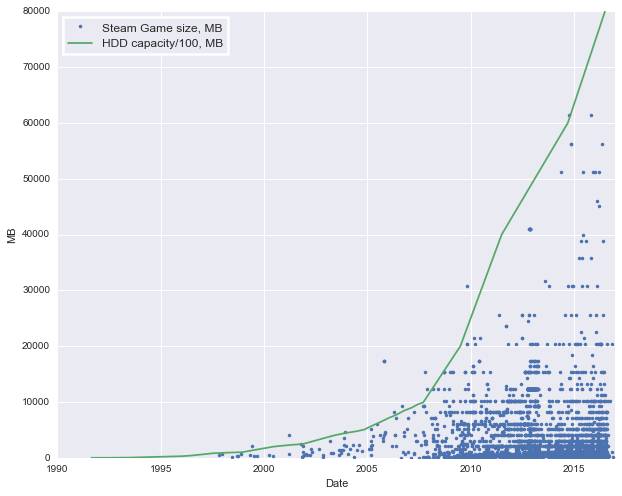

In [580]:
fig = plt.figure(figsize=[10,8])
plt.plot(map(toYearFraction, dates), sizes, '.', label='Steam Game size, Mb')
plt.plot(dates_hdd, map(lambda l: l*10, capacity_hdd), label='HDD capacity/100, Mb')
plt.ylim(-1, 8.0e4)
plt.ylabel('Mb')
plt.xlabel('Date')
leg = plt.legend(loc='upper left', fontsize='large', frameon=True)
leg.get_frame().set_linewidth(2.5)
plt.xlim(1990, 2017)

Собственно эта картинка и была целью работы. Видно, что максимальный размер игры и размер жесткого диска хорошо следуют друг другу, однако по-прежнему есть огромное число игр с малым весом.

C помощью Bokeh можно удобно исследовать данные:

In [ ]:
names = []
for _id in ids:
    found = False
    for app in apps_json['applist']['apps']:
        if app['appid'] == _id:
            names.append(app['name'])
            found = True
    if not found:
        names.append('#NO NAME#')


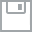
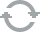
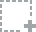
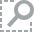
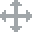
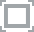
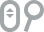
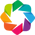
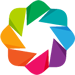
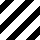
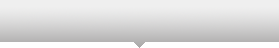
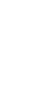
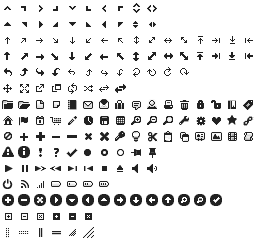
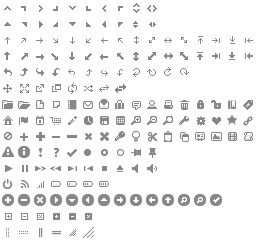
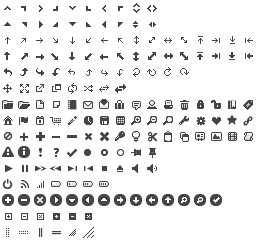
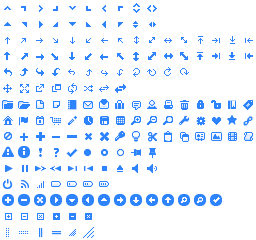
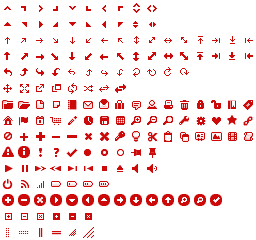
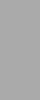

In [799]:
from bokeh.models import HoverTool, Range1d
from bokeh.plotting import figure, show, output_notebook
from bokeh.embed import notebook_div
from collections import OrderedDict
output_notebook()

TOOLS="crosshair,pan,wheel_zoom,box_zoom,reset,hover,previewsave"

p = figure(title='Steam Games: Release date vs Size', tools=TOOLS)
source = ColumnDataSource(
    data=dict(
        date=['%.2f'%s for s in map(toYearFraction, dates)],
        size=sizes,
        id=ids,
        name=[n[0:30] for n in names]
    )
)
p.circle(map(toYearFraction, dates), sizes, source = source)
hover = p.select(dict(type=HoverTool))
hover.tooltips = OrderedDict([
#     ("index", "$index"),
    ('date', '@date'),
    ('size', '@size'),
    ("id", "@id"),
    ('name', '@name'),
])

show(p)

Отберу несколько игр, чтобы сделать красоту:

In [800]:
milestone_ids = [38400, 65540, 21090, 32430, 206230, 201810, 379720, 209650, 292120, 41900]

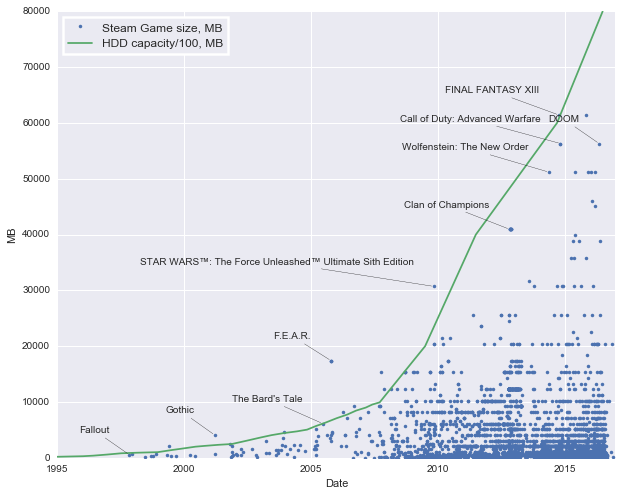

In [801]:
fig = plt.figure(figsize=[10,8])
plt.plot(map(toYearFraction, dates), sizes, '.', label='Steam Game size, MB')
plt.plot(dates_hdd, map(lambda l: l*10, capacity_hdd), label='HDD capacity/100, MB')
plt.ylim(-1, 8.0e4)
plt.ylabel('MB')
plt.xlabel('Date')
leg = plt.legend(loc='upper left', fontsize='large', frameon=True)
leg.get_frame().set_linewidth(2.5)
height = img.size[1]
plt.xlim(1995, 2017)

labels=[]
milestones=[]
for mil in milestone_ids:
    ind = ids.index(mil)
    labels.append(names[ind])
    milestones.append((toYearFraction(dates[ind]), sizes[ind]))
for label, x, y in zip(labels, zip(*milestones)[0], zip(*milestones)[1]):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'), fontsize=10)

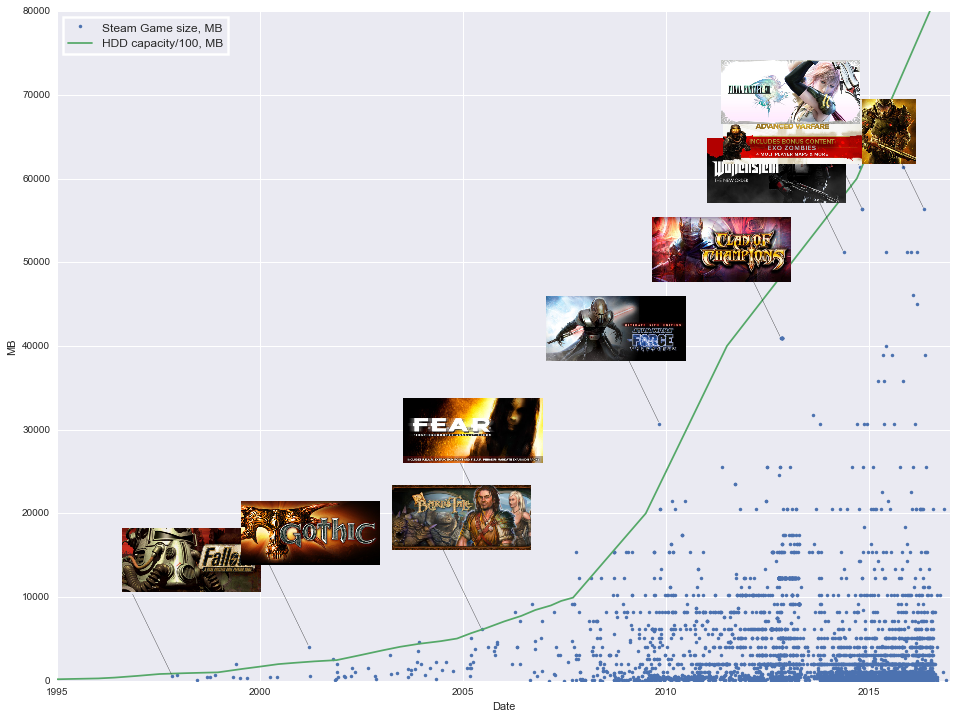

In [802]:
import urllib, cStringIO
from PIL import Image

fig = plt.figure(figsize=[16,12])
plt.plot(map(toYearFraction, dates), sizes, '.', label='Steam Game size, MB')
plt.plot(dates_hdd, map(lambda l: l*10, capacity_hdd), label='HDD capacity/100, MB')
plt.ylim(-1, 8.0e4)
plt.ylabel('MB')
plt.xlabel('Date')
leg = plt.legend(loc='upper left', fontsize='large', frameon=True)
leg.get_frame().set_linewidth(2.5)
height = img.size[1]
plt.xlim(1995, 2017)
labels=[]
milestones=[]
for mil in milestone_ids:
    ind = ids.index(mil)
    labels.append(names[ind])
    milestones.append((toYearFraction(dates[ind]), sizes[ind]))
coords = []
for label, x, y in zip(labels, zip(*milestones)[0], zip(*milestones)[1]):
    coord = plt.annotate('', xy = (x, y), xytext = (x-1, y+10000), textcoords = 'data', ha = 'right', va = 'bottom',
        arrowprops = dict(arrowstyle = '-', connectionstyle = 'arc3,rad=0'), fontsize=10)
    coords.append(coord.xy)

for label, x, y in zip(labels, zip(*milestones)[0], zip(*milestones)[1]):
    ind = labels.index(label)
    coord = coords[ind]
    xcord = (coord[0]-1995.-1.)/22.
    xcord = xcord*(0.8-0.125) + 0.125
    ycord = (coord[1]+1.+10000)/80000
    ycord = ycord*(0.8-0.088) + 0.088
    
    file = cStringIO.StringIO(
        urllib.urlopen('http://cdn.akamai.steamstatic.com/steam/apps/%s/header.jpg'%milestone_ids[ind]).read())
    img = Image.open(file)
    newax = fig.add_axes([xcord, ycord, 0.12, 0.12], anchor='NE', zorder=1)
    newax.imshow(img)
    newax.axis('off')
plt.show()

Посмотрим, как меняется средний размер игр на основе собранных данных:

In [520]:
dates_y = map(toYearFraction, dates)
tmp = sorted(zip(dates_y, sizes))
dates_y, sizes = zip(*tmp)

In [521]:
tmp = np.linspace(dates_y[0], dates_y[-1], 40)
zipped = np.array(zip(dates_y, sizes))
mean_data = []
max_data = []
for left, right in zip(tmp[:-1], tmp[1:]):
    mask = (zipped[:,0] > left) & (zipped[:,0] < right)
    if len(zipped[mask]) > 0:
        mean_data.append(((left+right)/2., zipped[mask][:,1].mean()))
        max_data.append(((left+right)/2., zipped[mask][:,1].max()))

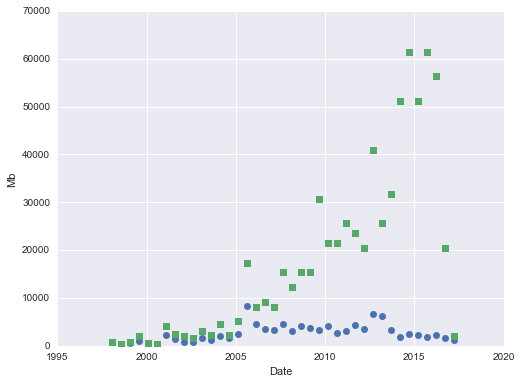

In [522]:
gsmean = zip(*mean_data)[1]
gsmax = zip(*max_data)[1]
dates_y = zip(*mean_data)[0]

fig = plt.figure(figsize=[8,6])
plt.plot(dates_y, gsmean, 'o')
plt.plot(dates_y, gsmax, 's')
plt.ylabel('Mb')
plt.xlabel('Date')

Видно, что средний размер игры не сильно меняется со временем, тогда как наиболее объемные игры занимают все больше и больше места на диске, возрастая вместе с объемом HDD.

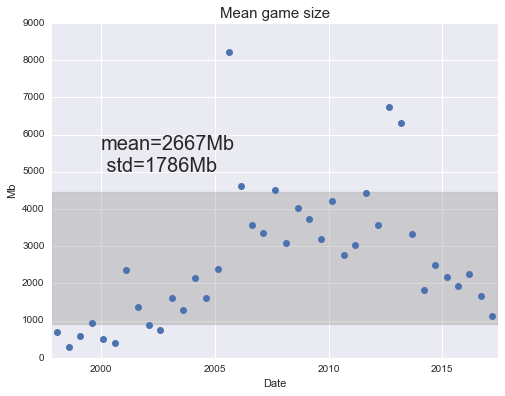

In [537]:
fig = plt.figure(figsize=[8,6])
plt.plot(dates_y, gsmean, 'o')
m,st = np.mean(gsmean), np.std(gsmean)
plt.text(2000, 5000, 'mean=%.0fMb\n std=%.0fMb' % (m, st), fontsize=20)
plt.fill_between(tmp, [m-st]*len(tmp), [m+st]*len(tmp), color='grey', alpha=0.3)
plt.xlim(tmp[0], tmp[-1])
plt.title('Mean game size', fontsize=15)
plt.ylabel('Mb')
plt.xlabel('Date')
plt.show()

Хорошо видно, что большинство средних лежит в диапазоне 2.5$\pm$1.7 Гб, что в целом согласуется со здравым смыслом здорового геймера. 

Напоследок посмотрим корреляцию между объемом жесткого диска и максимальным размером вышедших игр. Для этого точки графика надо интерполировать непрерывной функцией - можно например сплайном, но я возьму экспонету и сигмоиду - посмотрим, наблюдается ли муровский рост или уже насыщение:

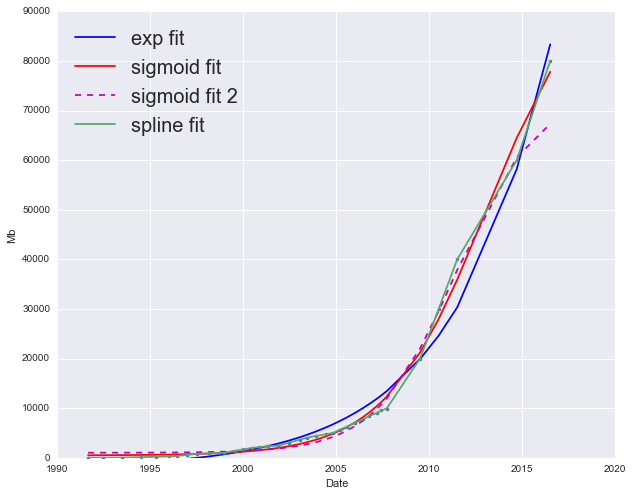

In [549]:
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit

capacity_hdd_100 = map(lambda l: l*10, capacity_hdd)

def expf(x, a, b, c, d):
    return a * np.exp(b * (x-d)) + c

def sigmoid(x, a, b, c, d):
    return a / (1 + np.exp(-(x-b)/c)) + d

spl = UnivariateSpline(dates_hdd, capacity_hdd_100, k=1, s=1)
popt1, pcov1 = curve_fit(expf, dates_hdd, capacity_hdd_100, p0=[1., 0.5, 10., 1990.])
popt2, pcov2 = curve_fit(sigmoid, dates_hdd, capacity_hdd_100, p0=[80000., 2012., 2.15, 0.])
popt3, pcov3 = curve_fit(sigmoid, dates_hdd[:-1], capacity_hdd_100[:-1], p0=[80000., 2012., 2.15, 0.])

fig = plt.figure(figsize=[10, 8])
plt.plot(xx, [func(x_, *popt1) for x_ in dates_hdd], 'b-', label="exp fit")
plt.plot(xx, [sigmoid(x_, *popt2) for x_ in dates_hdd], 'r-', label="sigmoid fit")
plt.plot(xx, [sigmoid(x_, *popt3) for x_ in dates_hdd], 'm--', label="sigmoid fit 2")
plt.plot(dates_hdd, capacity_hdd_100, '.')
plt.plot(dates_hdd, map(spl, dates_hdd), '-', label='spline fit')
plt.legend(loc='upper left', fontsize=20)
plt.ylim(0)
plt.ylabel('Mb')
plt.xlabel('Date')
plt.show()

Видно, хоть и не с первого взгляда, что лучше всего после сплайна описывает данные сигмоида (красный), которая еще не вышла на насыщение. Интересно, что если выкинуть последнюю точку, то новая сигмоида прошла центральную точку.

Посчитаем корреляцию (без последних двух точек, т.к. там будещие релизы и еще недостаточно данных для оценки максимума):

[]

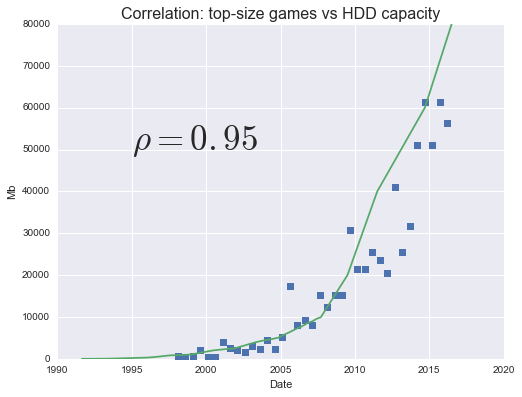

In [579]:
ccoef = np.corrcoef(gsmax[:-2], map(spl, dates_y)[:-2])[0, 1]
fig = plt.figure(figsize=[8,6])
plt.plot(dates_y[:-2], gsmax[:-2], 's')
plt.plot(dates_hdd, capacity_hdd_100, '-')
plt.title('Correlation: top-size games vs HDD capacity', fontsize=16)
plt.ylabel('Mb')
plt.xlabel('Date')
plt.text(1995, 50000, r'$\rho=%.2f$' % ccoef, fontsize=35)
plt.plot()

Корреляция очень сильная.